# Anamoly Detection

In [38]:
!pip install uv
!uv pip install nixtla --system
!uv pip install neuralforecast --system

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 76.9 MB/s eta 0:00:00
Using Python 3.10.12 environment at /usr
Audited 1 package in 141ms
Using Python 3.10.12 environment at /usr
Audited 1 package in 127ms


In [39]:
import time
import requests
import pandas as pd

from nixtla import NixtlaClient

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

In [41]:
from google.colab import userdata
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key=userdata.get('NIXTLA_API_KEY'))

In [42]:
import requests
import pandas as pd

def read_tsf_from_url(url):
    data = []
    start_date = pd.to_datetime('2002-01-01 00:00:00')

    # Fetch the content from the URL
    response = requests.get(url)
    response.raise_for_status()

    # Process each line of the file
    for line in response.text.splitlines():
        if line.startswith('T'):
            parts = line.strip().split(':')
            unique_id = parts[0] + '-' + parts[1]
            values = list(map(float, parts[3].split(',')[:-1]))

            # Generate datetime index at half-hour intervals
            periods = len(values)
            date_range = pd.date_range(start=start_date, periods=periods, freq='30min')

            # Append to data list
            for dt, value in zip(date_range, values):
                data.append([unique_id, dt, value])

    return pd.DataFrame(data, columns=['unique_id', 'ds', 'y'])

url = 'https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/australian_electricity_demand_dataset.tsf'
df = read_tsf_from_url(url)

In [43]:
df.groupby('unique_id').head(2)

,unique_id,ds,y
0,T1-NSW,2002-01-01 00:00:00,5714.045004
1,T1-NSW,2002-01-01 00:30:00,5360.189078
230735,T2-VIC,2002-01-01 00:00:00,3535.867064
230736,T2-VIC,2002-01-01 00:30:00,3383.499028
461470,T3-QUN,2002-01-01 00:00:00,3382.041342
461471,T3-QUN,2002-01-01 00:30:00,3288.315794
693741,T4-SA,2002-01-01 00:00:00,1191.078014
693742,T4-SA,2002-01-01 00:30:00,1219.589472
924524,T5-TAS,2002-01-01 00:00:00,315.915504
924525,T5-TAS,2002-01-01 00:30:00,306.245864


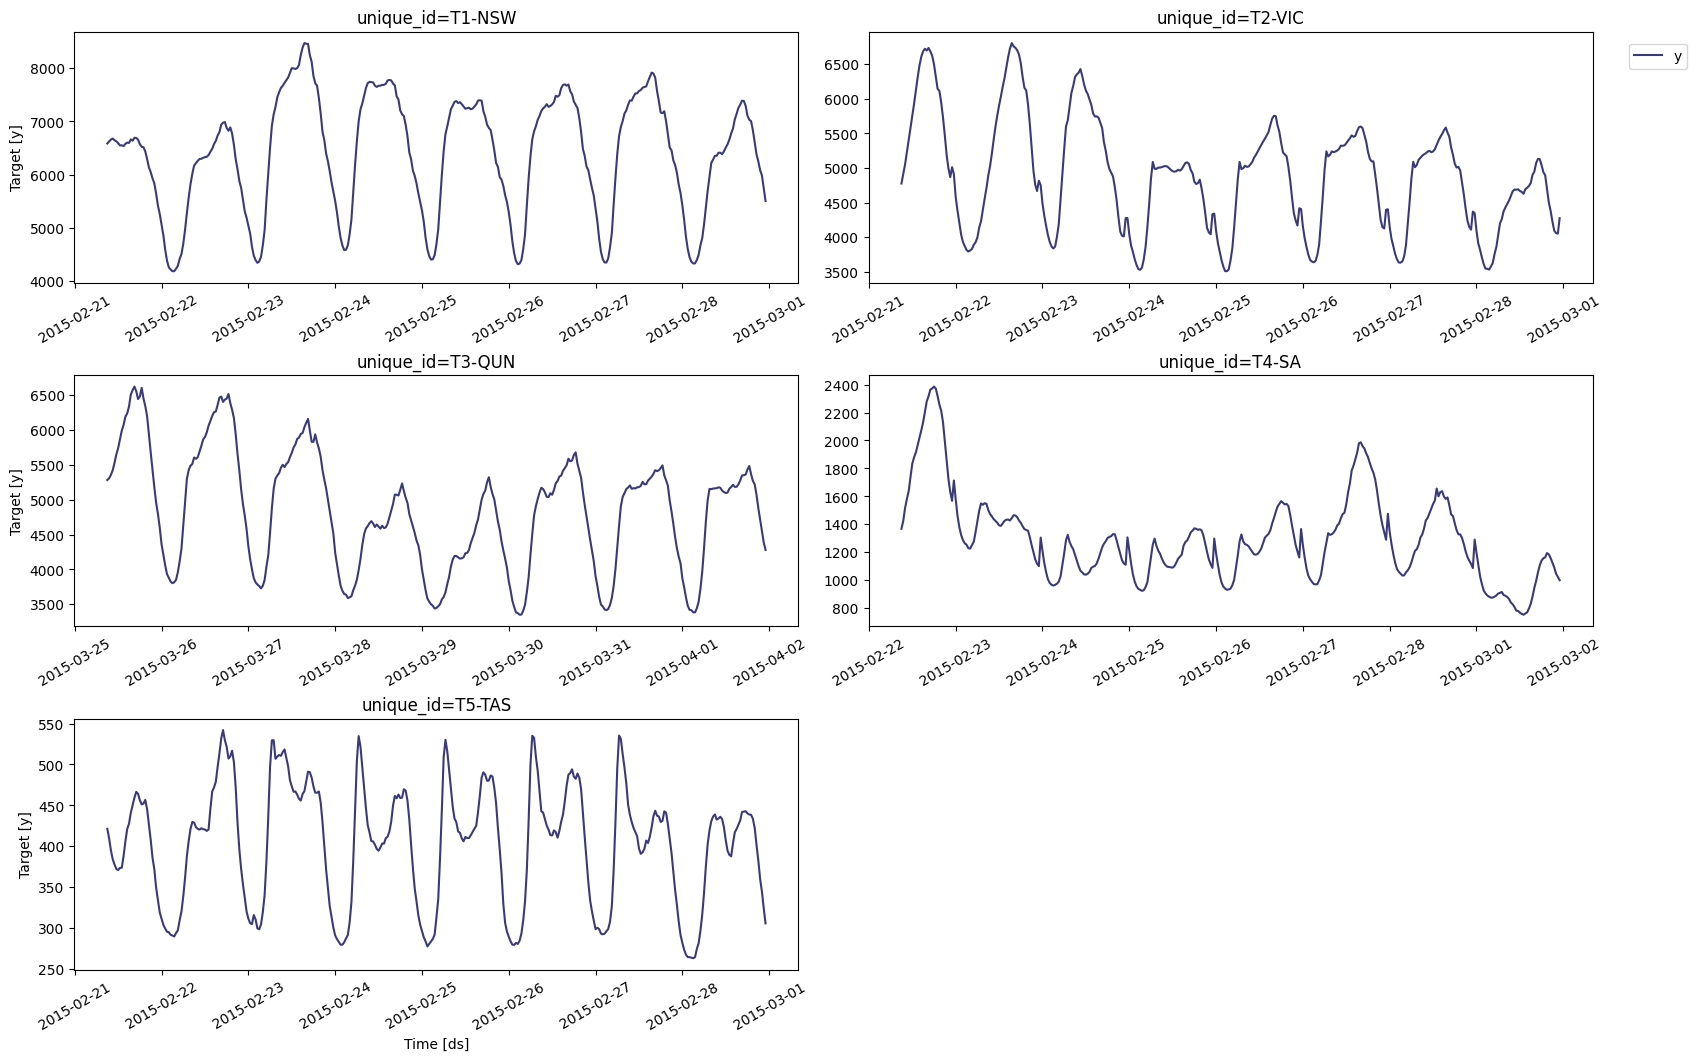

In [44]:
nixtla_client.plot(
    df,
    max_insample_length=365,
)

In [45]:
test_df = df.groupby('unique_id').tail(96)                                                             # 96 = 2 days (96 * 0.5h *  1 day/24h )

input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 21 days (1008 *0.5h * 1 day/24h)


<ipython-input-45-961b1ff3eaa7>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 21 days (1008 *0.5h * 1 day/24h)


In [46]:
import time
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=96,
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

Time (TimeGPT): 3.1617565155029297


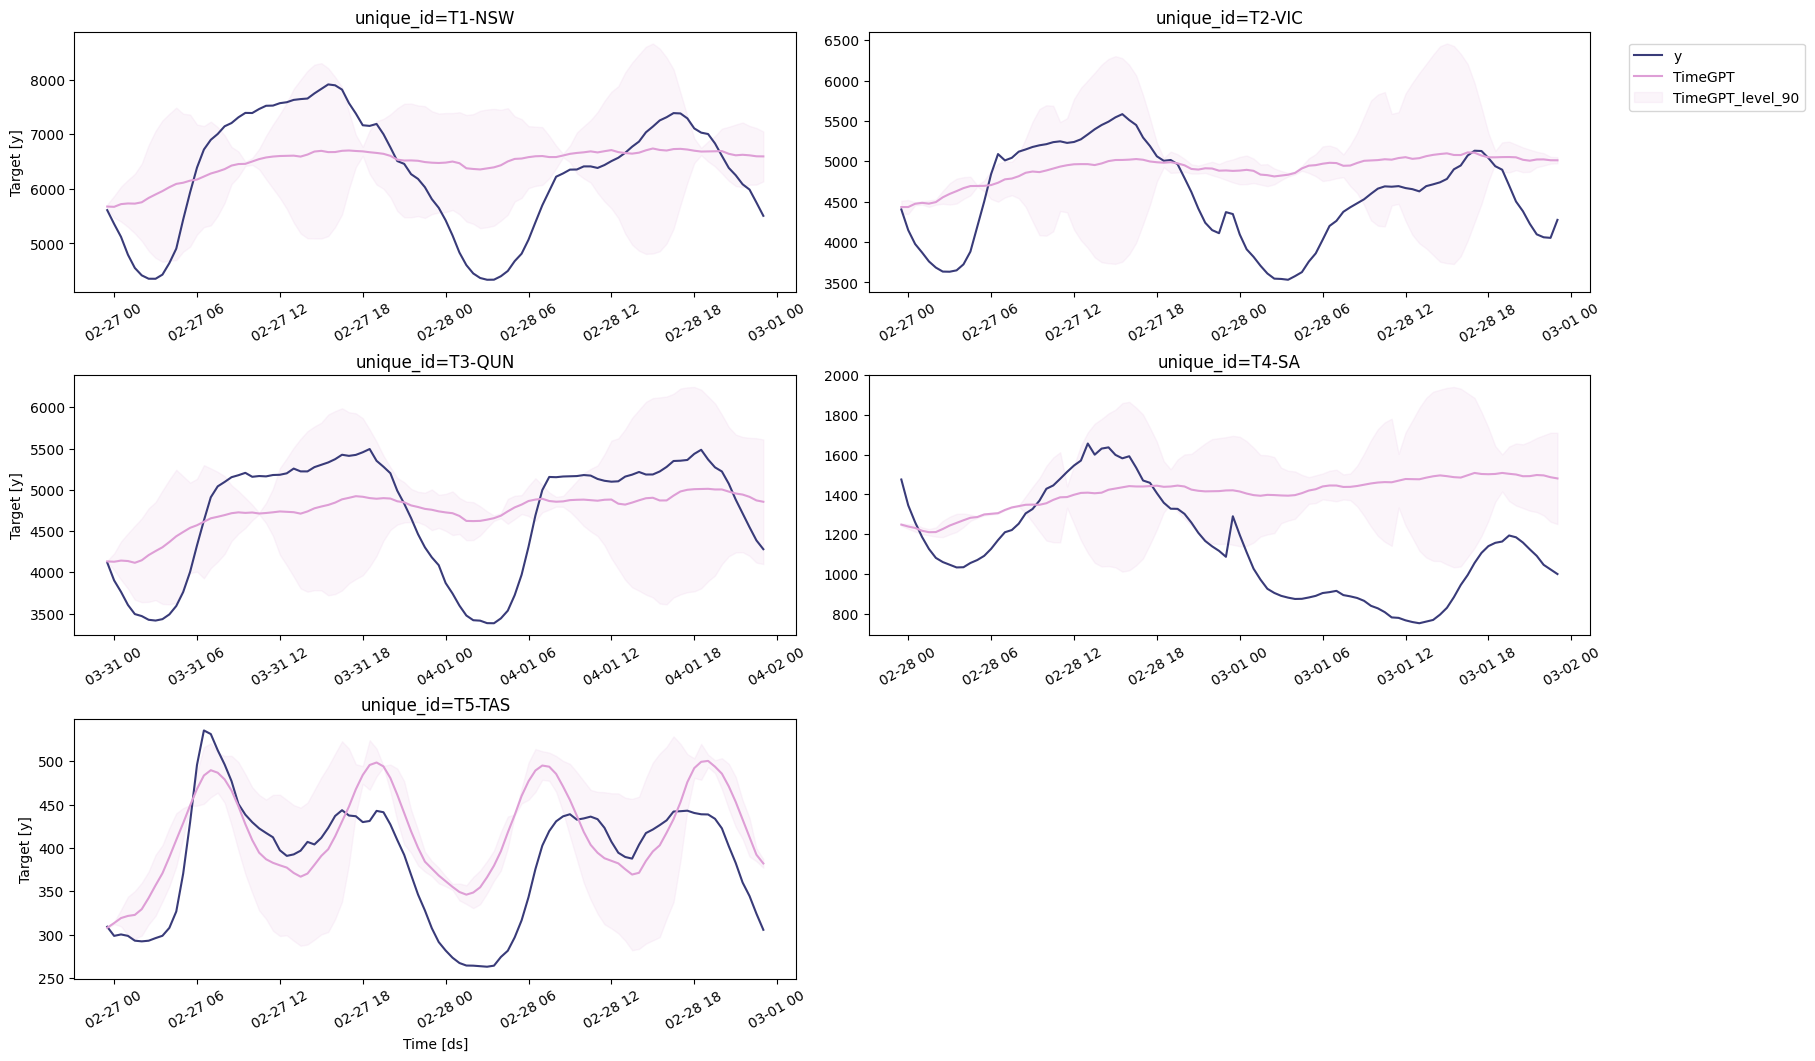

In [47]:
nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')


In [48]:
fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])

test_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])


In [49]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, smape

evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
average_metrics

,TimeGPT
metric,
mae,436.787046
smape,0.075237


In [50]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS

In [51]:
train_df = df.groupby('unique_id').apply(lambda group: group.iloc[-9696:-96]).reset_index(drop=True)

<ipython-input-51-dd4b155c9a49>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df.groupby('unique_id').apply(lambda group: group.iloc[-9696:-96]).reset_index(drop=True)


In [52]:
horizon = 96

models = [NHITS(h=horizon, input_size = 5*horizon, scaler_type='robust', batch_size=16, valid_batch_size=8)]

nf = NeuralForecast(models=models, freq='H')

start = time.time()

nf.fit(df=train_df)
nhits_preds = nf.predict()

end = time.time()

nhits_duration = end - start

print(f"Time (N-HiTS): {nhits_duration}")

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.727    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Time (N-HiTS): 1063.2308580875397


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [53]:
preds_df = pd.merge(test_df, nhits_preds, 'left', ['unique_id', 'ds'])

evaluation = evaluate(
    preds_df,
    metrics=[mae, smape],
    models=["NHITS"],
    target_col="y",
    id_col='unique_id'
)


average_metrics = evaluation.groupby('metric')['NHITS'].mean()
print(average_metrics)

metric
mae      217.768283
smape      0.047968
Name: NHITS, dtype: float64
